# Extracting a pore network using PoreSpy and loading into OpenPNM


In [1]:
import porespy as ps
print("PoreSpy version is " + ps.__version__)
import openpnm as op
print("OpenPNM version is " + op.__version__)
import scipy as sp
import matplotlib.pyplot as plt

PoreSpy version is 1.1.2
OpenPNM version is 2.1.0b1


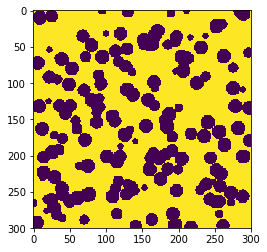

In [2]:
im = ps.generators.overlapping_spheres(shape=[300, 300, 300], radius=10, porosity=0.5, iter_max=0)
plt.imshow(im[:, :, 50])

In [3]:
import scipy.ndimage as spim
def show3D(im):
    im = spim.rotate(input=im, angle=22.5, axes=[0, 1], order=0)
    im = spim.rotate(input=im, angle=45, axes=[2, 1], order=0)
    im = spim.rotate(input=im, angle=-17, axes=[0, 1], order=0, reshape=False)
    mask = im != 0
    view = sp.where(mask.any(axis=2), mask.argmax(axis=2), 0)
    view = view.max() - view
    f = view.max()/5
    view[view == view.max()] = -f
    view = (view + f)**2
    return view

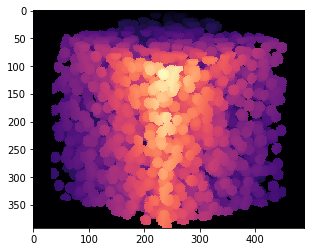

In [4]:
t = show3D(~im)
plt.imshow(t, cmap=plt.cm.magma)

In [5]:
snow = ps.networks.snow(im=im, boundary_faces=['right'])

____________________________________________________________
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  2311
Peaks after trimming saddle points:  1617
Peaks after trimming nearby peaks:  1578
____________________________________________________________
Extracting pore and throat information from image


100%|██████████████████████████████████████████████████████████████████████████████| 1694/1694 [00:28<00:00, 58.50it/s]


In [6]:
net = op.network.GenericNetwork()
net.update(snow)

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.topotools.topotools._scale_3d_axes 
    TIME STAMP: 2019-05-27 23:22:19,200    


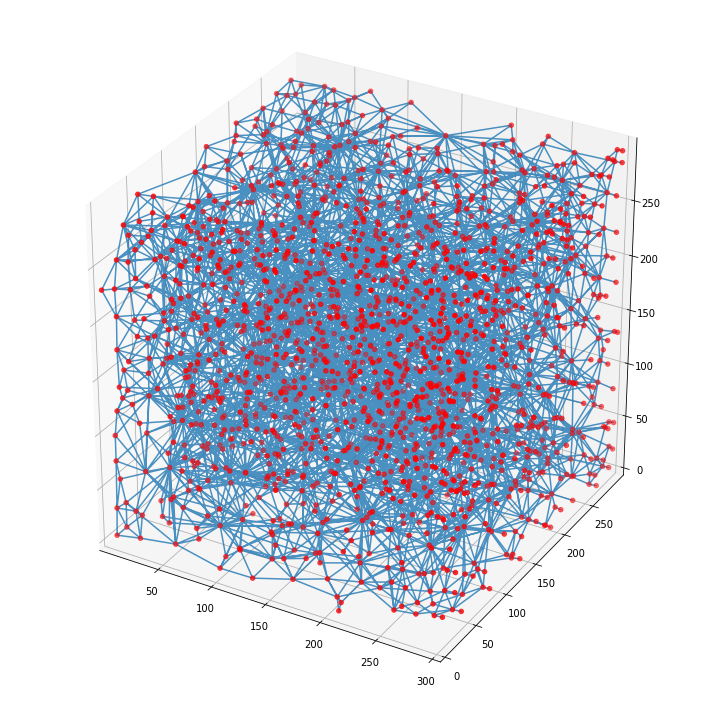

In [7]:
fig = op.topotools.plot_connections(network=net, alpha=0.8)
fig = op.topotools.plot_coordinates(network=net, fig=fig, color='r')
fig.set_size_inches(10, 10)
fig.tight_layout()

In [8]:
geo = op.geometry.Imported(net)

In [9]:
m = sp.meshgrid(range(50, 250, 10), range(50, 295, 10))
m = sp.vstack([-10*sp.ones_like(m[1].flatten()), m[0].flatten(), m[1].flatten()]).T
op.topotools.find_surface_pores(network=net, markers=m, label='left')
op.topotools.clone_pores(network=net, pores=net.pores('left'), labels='left_boundary')
net['pore.coords'][net.pores('left_boundary')] *= [0, 1, 1]

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.topotools.topotools.clone_pores 
    TIME STAMP: 2019-05-27 23:22:20,052    


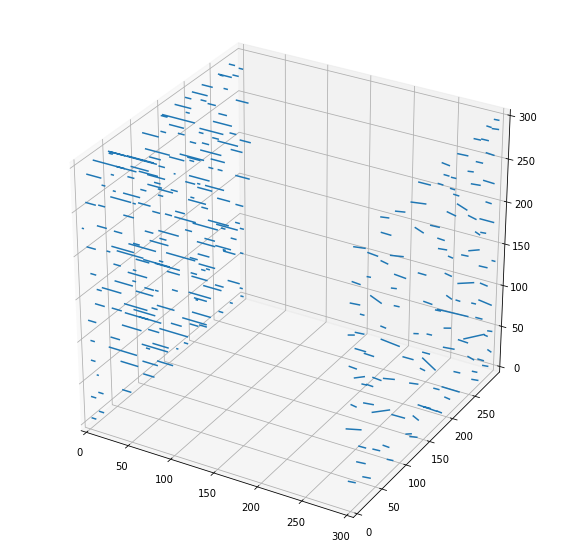

In [10]:
Ps = net.pores('boundary')
net['pore.right_boundary'] = False
net['pore.right_boundary'][Ps] = True
Ts = net.find_neighbor_throats(pores=net.pores('right_boundary'))
net['throat.right_boundary'] = False
net['throat.right_boundary'][Ts] = True
fig = op.topotools.plot_connections(network=net, throats=net.throats(['left_boundary', 'right_boundary']))
fig.set_size_inches(10, 10)

In [18]:
proj = net.project
for geo in proj.geometries().values():
    proj.purge_object(geo)

In [19]:
Ps = net.pores('left_boundary')
Ts = net.find_neighbor_throats(pores=Ps)
geo_bnd = op.geometry.StickAndBall(network=net, pores=Ps, throats=Ts)

c:\users\jeff\dropbox\flash sync\code\git\openpnm\openpnm\models\geometry\throat_endpoints.py:134: RuntimeWarning: invalid value encountered in greater
  mask = Dt > D1
C:\Users\Jeff\Anaconda3\lib\site-packages\numpy\lib\scimath.py:122: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
c:\users\jeff\dropbox\flash sync\code\git\openpnm\openpnm\models\geometry\throat_endpoints.py:137: RuntimeWarning: invalid value encountered in greater
  mask = Dt > D2
c:\users\jeff\dropbox\flash sync\code\git\openpnm\openpnm\models\geometry\throat_endpoints.py:157: RuntimeWarning: invalid value encountered in less
  overlap = L - 0.5 * (D1+D2) < 0
c:\users\jeff\dropbox\flash sync\code\git\openpnm\openpnm\models\geometry\throat_endpoints.py:158: RuntimeWarning: invalid value encountered in less
  mask = overlap & (Dt < h)


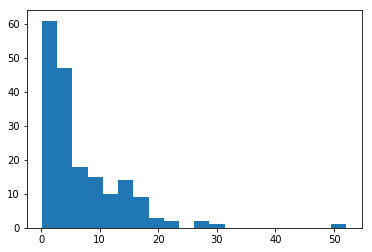

In [20]:
geo_bnd.show_hist('pore.diameter')